# Fine tuning our fastai model with new data

We have now created an expanded version of our training data using `Snorkel`. We can see if this improves the performance of our model compared to our [previous attempt](01_BL_fiction_non_fiction.ipynb). 

We could do this by creating a new model and training from scratch. However, our previous model was already doing quite well so it might make sense to try and benefit from what the model has already learned and fine-tune our previous model instead. 

## Why fine tune our model?

Updating our previous model may also allow us to train for less time since the model isn't starting from 'scratch'. In particular, we saw previously that training a language model for our data was time consuming so we may want to limit how much we repeat this step. In some contexts it is likely that you will often want to train a model and update it with new data. This new data may, for example, we arriving as part of a crowdsourcing task. Instead of waiting for all of the data to arrive before training a model you will often want to train as you get new data. In other settings you may have data that is temporal. For example a predictive model that tries to predict some outcome for the next month will at some point have the next's months training data available.

We'll start by installing the same version of `fastai` we used previously.

In [1]:
!pip install fastai==2.5.2

     |████████████████████████████████| 186 kB 8.2 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 2.3 kB/s 
     |████████████████████████████████| 56 kB 6.1 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext

We then import the necessary packages

In [2]:
import pandas as pd
import torch
from fastai.text.all import *

## Loading our snorkel generated data

We'll define *some* of the `dtypes` for the data we generated using `Snorkel` previously.

In [3]:
dtypes = {
    "BL record ID": "string",
    "Type of resource": "category",
    "Name": "category",
    "Type of name": "category",
    "Country of publication": "category",
    "Place of publication": "category",
    "Genre": "category",
    "Dewey classification": "string",
    "BL record ID for physical resource": "string",
    "annotator_main_language": "category",
    "annotator_summaries_language": "string",
}

We can now grab the new Snorkel data

In [4]:
!wget https://transfer.sh/H3zJcc/snorkel_train.csv

--2021-11-15 18:18:25--  https://transfer.sh/H3zJcc/snorkel_train.csv
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10211140 (9.7M) [text/csv]
Saving to: ‘snorkel_train.csv’

snorkel_train.csv   100%[===================>]   9.74M  4.22MB/s    in 2.3s    

2021-11-15 18:18:29 (4.22 MB/s) - ‘snorkel_train.csv’ saved [10211140/10211140]



In [5]:
df = pd.read_csv("snorkel_train.csv", dtype=dtypes)

In [6]:
df.head(2)

,BL record ID,Type of resource,Name,Dates associated with name,Type of name,Role,All names,Title,Variant titles,Series title,Number within series,Country of publication,Place of publication,Publisher,Date of publication,Edition,Physical description,Dewey classification,BL shelfmark,Topics,Genre,Languages,Notes,BL record ID for physical resource,classification_id,user_id,created_at,subject_ids,annotator_date_pub,annotator_normalised_date_pub,annotator_edition_statement,annotator_genre,annotator_FAST_genre_terms,annotator_FAST_subject_terms,annotator_comments,annotator_main_language,annotator_other_languages_summaries,annotator_summaries_language,annotator_translation,annotator_original_language,annotator_publisher,annotator_place_pub,annotator_country,annotator_title,Link to digitised book,annotated,is_valid,text_len,fiction_prob,non_fiction_prob,snorkel_genre,snorkel_label
0,014616539,Monograph,NaN,NaN,NaN,NaN,"Hazlitt, William Carew, 1834-1913 [person]",The Baron's Daughter. A ballad by the author of Poetical Recreations [i.e. William C. Hazlitt] . F.P,Single Works,NaN,NaN,Scotland,Edinburgh,"Ballantyne, Hanson",1877,NaN,20 pages (4°),<NA>,Digital Store 11651.h.6,NaN,NaN,English,NaN,000206670,263940444.0,3.0,2020-07-27 07:35:13 UTC,44330917.0,1877,1877,NONE,Fiction,655 7 $aPoetry$2fast$0(OCoLC)fst01423828,NONE,NaN,NaN,No,<NA>,No,NaN,Ballantyne Hanson & Co.,Edinburgh,stk,The Baron's Daughter. A ballad by the author of Poetical Recreations [i.e. William C. Hazlitt] . F.P,http://access.bl.uk/item/viewer/ark:/81055/vdc_00000002F718,True,False,100,0.999940,0.000060,Fiction,NaN
1,014616686,Monograph,"Earle, John Charles",NaN,person,NaN,"Earle, John Charles [person]","Maximilian, and other poems, etc",NaN,NaN,NaN,England,London,NaN,1868,NaN,NaN,<NA>,Digital Store 11648.i.8,NaN,Poetry or verse,English,NaN,001025896,265570129.0,3.0,2020-08-03 07:25:30 UTC,44331725.0,1868,1868,NONE,Fiction,655 7 $aPoetry$2fast$0(OCoLC)fst01423828,NONE,NaN,NaN,No,<NA>,No,NaN,"Burns, Oates, & Co.",London,enk,"Maximilian, and other poems, etc",http://access.bl.uk/item/viewer/ark:/81055/vdc_00000002F2AA,True,False,32,0.982546,0.017454,Fiction,NaN


### Downloading our previous model 

Since we're going to try and fine tune the model we created previously we need to have it available. We can grab it using [`wget`](https://www.gnu.org/software/wget/)

In [7]:
!wget -O 20210928-model.pkl https://zenodo.org/record/5245175/files/20210928-model.pkl?download=1

--2021-11-15 18:18:30--  https://zenodo.org/record/5245175/files/20210928-model.pkl?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 158529715 (151M) [application/octet-stream]
Saving to: ‘20210928-model.pkl’

20210928-model.pkl  100%[===================>] 151.19M  15.1MB/s    in 9.7s    

2021-11-15 18:18:41 (15.6 MB/s) - ‘20210928-model.pkl’ saved [158529715/158529715]



We can use `fastai`'s `load_learner` function to load our model.

In [17]:
learn = load_learner("20210928-model.pkl", cpu=False)

We can make sure our model is using the GPU

In [18]:
learn.cuda()

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(17392, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(17392, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True

When we export our `fastai` `learner` it includes the vocab for the model. This is made up of two vocabs, the first of which includes the vocab for the language model.

In [10]:
learn.dls.vocab[0]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 ',',
 'the',
 '.',
 'of',
 'a',
 'and',
 '…',
 'in',
 '[',
 ']',
 'by',
 'with',
 'etc',
 '-',
 'de',
 'to',
 "'",
 ':',
 ';',
 'from',
 "'s",
 'an',
 'on',
 'or',
 'history',
 'la',
 'novel',
 'poems',
 'et',
 'edition',
 'illustrations',
 '(',
 ')',
 'j.',
 'und',
 'der',
 'other',
 'des',
 'for',
 'illustrated',
 'new',
 'verse',
 'notes',
 'edited',
 'life',
 'author',
 'w.',
 'h.',
 'von',
 'its',
 'a.',
 'poem',
 'c.',
 'second',
 'tale',
 'les',
 'at',
 'en',
 'story',
 'i',
 'e.',
 'i.e.',
 'm.',
 'acts',
 'historical',
 'account',
 'g.',
 'his',
 'le',
 'du',
 'die',
 'f.',
 'being',
 'map',
 'par',
 'plates',
 'two',
 'which',
 '&',
 'geschichte',
 'r.',
 'maps',
 'five',
 'sketches',
 'sur',
 'england',
 'translated',
 's.',
 'mit',
 '1',
 'histoire',
 'john',
 '3',
 'years',
 'guide',
 't.',
 'is',
 'book',
 'first',
 'à',
 'as',
 'three',
 'works',
 'romance',
 'some',
 'prose',
 'wa

We can quickly check what our columns are:

In [11]:
df.columns

Index(['BL record ID', 'Type of resource', 'Name',
       'Dates associated with name', 'Type of name', 'Role', 'All names',
       'Title', 'Variant titles', 'Series title', 'Number within series',
       'Country of publication', 'Place of publication', 'Publisher',
       'Date of publication', 'Edition', 'Physical description',
       'Dewey classification', 'BL shelfmark', 'Topics', 'Genre', 'Languages',
       'Notes', 'BL record ID for physical resource', 'classification_id',
       'user_id', 'created_at', 'subject_ids', 'annotator_date_pub',
       'annotator_normalised_date_pub', 'annotator_edition_statement',
       'annotator_genre', 'annotator_FAST_genre_terms',
       'annotator_FAST_subject_terms', 'annotator_comments',
       'annotator_main_language', 'annotator_other_languages_summaries',
       'annotator_summaries_language', 'annotator_translation',
       'annotator_original_language', 'annotator_publisher',
       'annotator_place_pub', 'annotator_country', 'annot

We'll create a `dataloaders` object which will contain the new data we'll use to update our previous model. This will probably look familiar from our previous notebook. The main difference here is that we pass in the vocab for our previous language model data to the `text_vocab` parameter. This makes sure that we have a consistent vocab.

In [12]:
dls = TextDataLoaders.from_df(
    df,
    text_col="Title",
    label_col="snorkel_genre",
    valid_col="is_valid",
    text_vocab=learn.dls.vocab[0],
)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [13]:
dls.show_batch()

,text,category
0,"xxbos xxmaj los xxmaj xxunk y las xxmaj maravillas del xxmaj mundo . … xxmaj anales del mundo desde los tiempos xxunk hasta nuestros dias . … xxmaj gran xxmaj memorandum histórico … que comprende xxunk las obras xxunk . xxmaj la xxmaj xxunk … xxmaj historia xxmaj universal , escrita por el xxunk xxmaj xxunk xxmaj xxunk y su xxunk celebrado xxmaj arte de xxunk los datos de las xxunk históricas , xxunk y otros antiguos documentos ; … continuada hasta hoy dia por xxup m. de xxmaj saint xxmaj xxunk ; la xxmaj historia de xxmaj xxunk el xxmaj grande , escrita por xxmaj xxunk xxmaj xxunk , la de xxmaj xxunk y xxmaj roma , xxmaj xxunk y los xxmaj xxunk , xxmaj xxunk y xxmaj xxunk , xxunk los xxunk xxmaj xxunk de este último ; la de la guerra de xxmaj xxunk y xxmaj xxunk",Non-fiction
1,"xxbos xxmaj platonis , et quæ vel xxmaj platonis xxunk xxunk , vel xxmaj xxunk solent xxunk xxunk , xxmaj xxunk omnia . xxmaj ad xxunk xxunk recensuit xxunk inde xxunk xxunk xxunk xxup i. xxmaj xxunk . xxmaj annotationibus xxunk xxmaj xxunk , xxmaj xxunk , xxmaj xxunk , xxmaj wyttenbachii , xxmaj xxunk , xxmaj xxunk , xxunk xxunk non xxunk xxmaj xxunk , xxmaj xxunk , xxmaj xxunk , xxmaj xxunk , xxmaj xxunk , xxmaj xxunk , xxmaj xxunk et xxmaj xxunk , xxunk ex commentariis xxunk xxunk excerpta . ( xxunk xxmaj xxunk vita xxunk xxmaj xxunk vita xxunk vita xxunk et xxunk xxunk xxunk veterum xxunk xxunk de xxmaj xxunk ejusque xxunk et xxunk xxmaj xxunk et xxunk scriptis atque xxunk dissertatio xxup j. xxup a. xxunk codicum xxup mss . xxmaj platonis ejusque xxunk e xxmaj xxunk xxmaj xxunk . xxmaj xxunk codicum",Non-fiction
2,"xxbos xxmaj narrative of xxmaj travels and xxmaj discoveries in xxmaj northern and xxmaj central xxmaj africa , in the years 1822 , 1823 , and 1824 , by xxmaj major xxmaj denham , xxmaj captain xxmaj clapperton and the late xxmaj doctor xxmaj xxunk … xxmaj with an appendix … by xxmaj major xxup d. xxmaj denham … and xxmaj captain xxup h. xxmaj clapperton [ including ' translations from the xxmaj arabic , of various letters and documents , brought from xxmaj xxunk and xxmaj soudan by xxmaj major xxmaj denham and xxmaj captain xxmaj clapperton . xxmaj by xxup a. xxmaj xxunk , ' ' botanical xxmaj appendix . xxmaj by xxmaj robert xxmaj brown , ' and ' letter to xxmaj major xxmaj denham , on the rock specimens brought from xxmaj africa . xxmaj by xxmaj charles xxmaj xxunk ' ] [ with plates and",Non-fiction
3,"xxbos xxmaj the xxmaj history of xxmaj england ; from the invasion of xxmaj julius xxmaj caesar to the xxmaj revolution in 1688 : by xxup d. xxmaj hume … xxmaj with a continuation , from that period to the death of xxmaj george the xxmaj second , by xxmaj tobias xxmaj smollett … and xxmaj chronological xxmaj records to the coronation of his present xxmaj majesty , xxmaj george the xxmaj fourth , by xxmaj john xxmaj burke … xxmaj with numerous engravings . ( historical xxmaj questions comprising a series of studies upon the most important passages in xxmaj xxunk 's xxmaj universal xxmaj histories ; commencing with xxmaj hume and xxmaj xxunk 's xxmaj history of xxmaj england . xxmaj by xxmaj robert xxmaj xxunk . )",Non-fiction
4,"xxbos xxmaj additional xxmaj reasons , for our immediately xxunk xxmaj spanish xxmaj america , deduced from the … present crisis : and containing valuable information , respecting the late important events , both at xxmaj buenos xxmaj ayres , and in the xxmaj xxunk : as well as with respect to the present disposition and views of the xxmaj spanish xxmaj americans : being intended as a supplement to ' south xxmaj american xxmaj independence ' … xxmaj second edition , enlarged . ( letter to the xxmaj spanish xxmaj americans , by xxup d. xxmaj juan xxmaj xxunk xxmaj xxunk y xxmaj guzman , xxunk and proclamations by xxmaj general xxmaj miranda . )",Non-fiction
5,"xxbos xxmaj new xxmaj englands xxmaj xxunk xxmaj cast up at xxmaj london : or , a xxmaj relation of the xxmaj proceedings of the xxmaj cou

We can now assign a new dataloader to our learner object. This will then be used to train our model.

In [19]:
learn.dls = dls

As we've done previously we'll use the learning rate finder to try and find a sensible learning rate.

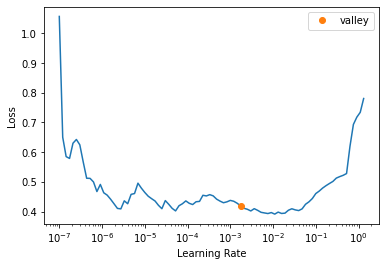

In [15]:
suggested = learn.lr_find()

As before we now want to train our model, again we go a little bit wild with the number of epochs but use a callback to make sure our model stops training if we don't see any improvements. 

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.407947,0.172334,0.932061,0.932026,04:12
1,0.401191,0.122557,0.951139,0.951041,04:14
2,0.437112,0.148886,0.940238,0.940177,04:14
3,0.451716,0.109705,0.956395,0.956275,04:13
4,0.455507,0.189706,0.926222,0.926204,04:14
5,0.421345,0.123881,0.950944,0.950846,04:14
6,0.416993,0.115451,0.954448,0.954336,04:12
7,0.393227,0.226075,0.912206,0.912206,04:17
8,0.398733,0.113009,0.955811,0.955692,04:12
9,0.417066,0.117806,0.953475,0.953368,04:12


Better model found at epoch 0 with f1_score value: 0.9320256479232389.


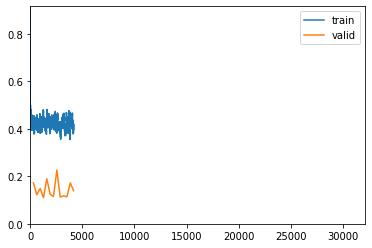

Better model found at epoch 1 with f1_score value: 0.9510406510603469.
Better model found at epoch 3 with f1_score value: 0.9562748837151331.
No improvement since epoch 3: early stopping


In [20]:
learn.fit_one_cycle(
    100,
    lr_max=1e-7,
    cbs=[
        ShowGraphCallback(),
        SaveModelCallback(monitor="f1_score"),
        EarlyStoppingCallback(monitor="f1_score", patience=10),
    ],
)

### Checking model performance

We can check our best model by calling `validate`. 

In [21]:
learn.validate()

(#3) [0.10970497131347656,0.9563947916030884,0.9562748837151331]

However, as we have done previously we always want to go back to our test data to see how our model is doing there.

In [22]:
df_test = pd.read_csv("test_errors.csv")

In [23]:
df_test = df_test[["title", "true_label"]]
df_test = df_test.dropna(subset=["true_label"]).copy()
df_test = df_test[df_test.true_label.isin({"non_fiction", "fiction"})]
test_data = learn.dls.test_dl(df_test.loc[:, "title"])
preds = learn.get_preds(dl=test_data)
probs = preds[0]
predictions = probs.argmax(1)
true_labels = df_test.true_label.astype("category").cat.codes

In [24]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

We can start with an overall f1score

In [25]:
f1_score(true_labels, predictions)

0.9557522123893805

But we probably want to use the classifcation report again to get a more detailed view on our model performance

In [26]:
print(
    classification_report(
        true_labels,
        predictions,
        target_names=learn.dls.vocab[1],
    )
)

              precision    recall  f1-score   support

     Fiction       0.95      0.88      0.91       296
 Non-fiction       0.94      0.97      0.96       554

    accuracy                           0.94       850
   macro avg       0.94      0.93      0.93       850
weighted avg       0.94      0.94      0.94       850



If you go back to our previous [fastai notebook](01_BL_fiction_non_fiction.ipynb) you will see that we do a get some small improvements in our model. These small improvements can add up, or be significant so we should be pleased to get this performance boost as a result of creating some more data. 

We'll save this new version of the model:


In [28]:
learn.export("20211115-model.pkl")

## Next steps

There is still quite a bit of playing around we could do here to eek out some more performance from our model. We haven't really done anything to improve our model training except look for a sensible learning rate. There are a whole bunch of other parameters we could try tweaking. For now we'll move on and see if using a transformer model will help. 